In [1]:
from pathlib import Path
import sys
sys.path.insert(0,'sim/lib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from distributions import CovidDistributions as d
from scipy.stats import lognorm
from scipy.stats import gamma


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
distr = d("GER")

In [3]:
T = 50
times = range(T)
#times = list(np.linspace(0,T+1,num=(T+1)*24,endpoint= False))

In [4]:
############## Expo -> Iasy -> Resi ###################
# expo-> iasy
mu_expo_to_iasy = distr.incubation_mean_of_lognormal-distr.median_infectious_without_symptom
std_expo_to_iasy = distr.incubation_std_of_lognormal
mulog_expo_to_iasy, stdlog_expo_to_iasy = d.normal_to_lognormal(d,mu = mu_expo_to_iasy,std = std_expo_to_iasy)
p_expo_to_iasy = lognorm.pdf(times, stdlog_expo_to_iasy,scale = np.exp(mulog_expo_to_iasy))

# iasy -> resi
mu_iasy_to_resi = distr.median_asymp_to_resi
std_iasy_to_resi = 1.0
mulog_iasy_to_resi, stdlog_iasy_to_resi = d.normal_to_lognormal(d,mu = mu_iasy_to_resi,std = std_iasy_to_resi)
p_iasy_to_resi = lognorm.pdf(times, stdlog_iasy_to_resi,scale = np.exp(mulog_iasy_to_resi))

# convolution
p_expo_iasy_resi = np.convolve(p_expo_to_iasy,p_iasy_to_resi)[:T]



##################### Expo -> Ipre -> Isym -> Resi #####################
# expo -> ipre

mu_expo_to_ipre = distr.incubation_mean_of_lognormal-distr.median_infectious_without_symptom
std_expo_to_ipre = distr.incubation_std_of_lognormal
mulog_expo_to_ipre, stdlog_expo_to_ipre = d.normal_to_lognormal(d,mu = mu_expo_to_ipre,std = std_expo_to_ipre)
p_expo_to_ipre = lognorm.pdf(times, stdlog_expo_to_ipre,scale = np.exp(mulog_expo_to_ipre))

# ipre-> isym
mu_ipre_to_isym = distr.median_infectious_without_symptom
std_ipre_to_isym = 1.0
mulog_ipre_to_isym, stdlog_ipre_to_isym = d.normal_to_lognormal(d,mu = mu_ipre_to_isym,std = std_ipre_to_isym)
p_ipre_to_isym = lognorm.pdf(times, stdlog_ipre_to_isym,scale = np.exp(mulog_ipre_to_isym))

# isym -> resi
mu_isym_to_resi = distr.median_symp_to_resi
std_isym_to_resi = 1.0
mulog_isym_to_resi, stdlog_isym_to_resi = d.normal_to_lognormal(d,mu = mu_isym_to_resi,std = std_isym_to_resi)
p_isym_to_resi = lognorm.pdf(times,stdlog_isym_to_resi,scale = np.exp(mulog_isym_to_resi))

p_expo_ipre_isym_resi = np.convolve(np.convolve(p_expo_to_ipre,p_ipre_to_isym)[:T],p_isym_to_resi)[:T]

##################### Expo -> Ipre -> Isym -> Dead #####################

# isym -> dead
mu_isym_to_dead = distr.symp_to_death_mean_of_lognormal
std_isym_to_dead = 1.0
mulog_isym_to_dead, stdlog_isym_to_dead = d.normal_to_lognormal(d,mu = mu_isym_to_dead,std = std_isym_to_dead)
p_isym_to_dead = lognorm.pdf(times,stdlog_isym_to_dead,scale = np.exp(mulog_isym_to_dead))

p_expo_ipre_isym_dead = np.convolve(np.convolve(p_expo_to_ipre,p_ipre_to_isym)[:T],p_isym_to_dead)[:T]

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/scipy/_lib/_util.py:23: RuntimeWarning: invalid value encountered in multiply
  out = np.ones(shape, dtype=bool) * value


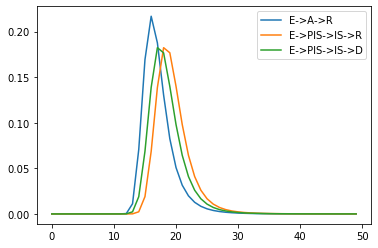

In [5]:
plt.plot(p_expo_iasy_resi, label = "E->A->R")
plt.plot(p_expo_ipre_isym_resi, label = "E->PIS->IS->R")
plt.plot(p_expo_ipre_isym_dead, label = "E->PIS->IS->D")
plt.legend()

In [6]:
num_age_groups = len(distr.p_hospital_by_age)
asym_frac_ages = distr.alpha*np.ones(num_age_groups) ##fraction of asymptomatic nodes
hosp_frac_ages = distr.p_hospital_by_age
dead_frac_ages = distr.fatality_rates_by_age

#t_ipre_resi = np.convolve(t_ipre_isym,t_isym_resi)[0:len(times)]
#t_ipre_hosp = np.convolve(t_ipre_isym,t_isym_hosp)[0:len(times)]
#t_ipre_dead = np.convolve(t_ipre_isym,t_isym_dead)[0:len(times)]

#t_symp_path = np.outer(hosp_frac_ages,t_ipre_hosp) + np.outer(dead_frac_ages,t_ipre_dead) + np.outer(1-dead_frac_ages-hosp_frac_ages,t_ipre_resi)
tau_recovery = np.outer(asym_frac_ages,p_expo_iasy_resi) \
    + np.outer((1-asym_frac_ages)*(1-dead_frac_ages),p_expo_ipre_isym_resi) \
    + np.outer((1-asym_frac_ages)*(dead_frac_ages),p_expo_ipre_isym_dead)
#np.savetxt("tau_recovery.txt",tau_recovery)

In [7]:
#lognorm fit
tau_recovery_mean = np.mean(tau_recovery,axis = 0)
mu_tau_recovery = np.sum(times*tau_recovery_mean)
std_tau_recovery = np.sqrt(np.sum( np.square(times)*tau_recovery_mean) - np.square(mu_tau_recovery))
mulog_tau_recovery, stdlog_tau_recovery = d.normal_to_lognormal(d,mu = mu_tau_recovery, std = std_tau_recovery)
fittedplog = lognorm.pdf(times, stdlog_tau_recovery, scale = np.exp(mulog_tau_recovery))


In [10]:
def gamma_params(mn, sd):
    scale = (sd**2)/mn
    shape = mn/scale

    return(shape, scale)
k_rec_gamma, scale_rec_gamma = gamma_params(mu_tau_recovery,std_tau_recovery)
fitted_gamma = gamma.pdf(times,k_rec_gamma, scale = scale_rec_gamma)


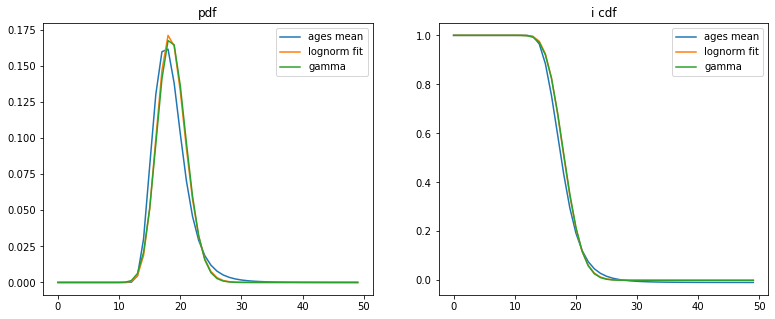

In [17]:
ag = 0
fig, axs  = plt.subplots(1,2,figsize = (13,5))
#for ag in range(num_age_groups):
    #axs[0].plot(times,tau_recovery[ag],label = f"age group {ag}")
    #axs[1].plot(times,1-np.cumsum(tau_recovery[ag]),label = f"age group {ag}")

axs[0].plot(times,tau_recovery_mean,label = f"ages mean")
axs[0].plot(times,fittedplog, label = "lognorm fit")
axs[0].plot(times,fitted_gamma, label = "gamma")
axs[1].plot(times,1-np.cumsum(tau_recovery_mean),label = f"ages mean")
axs[1].plot(times,1-np.cumsum(fittedplog), label = "lognorm fit")
axs[1].plot(times,1-np.cumsum(fitted_gamma), label = "gamma")
axs[0].legend()
axs[1].legend()
axs[0].set_title("pdf")
axs[1].set_title("i cdf")
fig.show()

# Time dependent infectivity
expo state not contagious

In [65]:
# use sigmoid function
def sig(t,alpha,t0):
    return 1/(1 + np.exp(-alpha*(t-t0)))



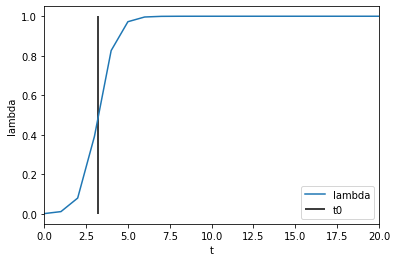

In [66]:
t0 = distr.incubation_mean_of_lognormal - distr.median_infectious_without_symptom
alpha = 2
plt.plot(times,sig(np.array(times),alpha,t0), label = "lambda")
plt.vlines(t0,ymin = 0,ymax = 1, label = "t0")
plt.xlim([0,20])
plt.xlabel("t")
plt.ylabel("lambda")
plt.legend()
